# 1 Autoencoder

-- A convolutional autoencoder is a particular 
avor of autoencoder where we
use convolutional layers instead of dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should be
able to do better using convolutional layers instead of Dense layers.

-- Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we've used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.

-- An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

-- After training your network, visualize some examples of input images and
their decoded reconstruction.

In [0]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Conv1D,Conv2D,GlobalMaxPooling1D, MaxPooling2D, UpSampling2D,Dropout,Flatten, Embedding, LSTM
from keras.models import Model,Sequential
from keras import backend as K
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

from keras.utils import np_utils
from keras.callbacks import EarlyStopping  
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.text import Tokenizer
from string import printable
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers

Using TensorFlow backend.


### Data Preperation

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Train the Autoencoder

In [0]:
# Add Layers from the blog
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [0]:
#from keras.callbacks import TensorBoard
auto_encoder_result = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.3728 - val_loss: 0.3340
Epoch 2/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3241 - val_loss: 0.3211
Epoch 3/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.3143 - val_loss: 0.3148
Epoch 4/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3075 - val_loss: 0.3205
Epoch 5/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3030 - val_loss: 0.3030
Epoch 6/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.3007 - val_loss: 0.3000
Epoch 7/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.2988 - val_loss: 0.3013
Epoch 8/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.2969 - val_loss: 0.2982
Epoch 9/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.2958 - val_loss: 0.

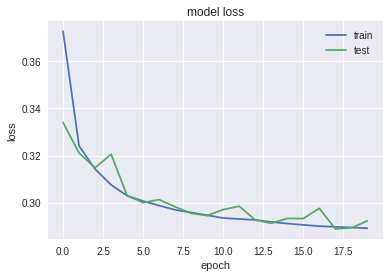

In [0]:
# Evaluate

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(auto_encoder_result)

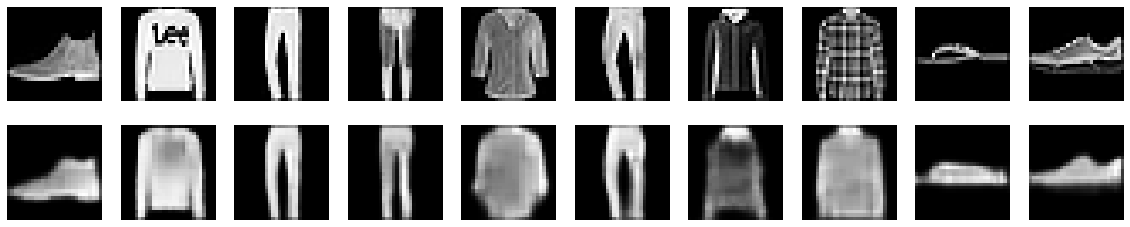

In [0]:
#decode image and visualize
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you've made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model's performance on training
set and test set.

### Data Preperation

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

# make a categorical clothing type
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Add Layers

In [0]:
model = Sequential()

model.add(Conv2D(filters = 64,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))


model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                102464    
__________

In [0]:
model_training = model.fit(x_train,
                             y_train,
                             batch_size=128,
                             epochs=30,
                             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 137us/step - loss: 0.7417 - acc: 0.7317 - val_loss: 0.4370 - val_acc: 0.8349
Epoch 2/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.4759 - acc: 0.8298 - val_loss: 0.3550 - val_acc: 0.8713
Epoch 3/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.4183 - acc: 0.8506 - val_loss: 0.3376 - val_acc: 0.8743
Epoch 4/30
60000/60000 [==============================] - 7s 120us/step - loss: 0.3846 - acc: 0.8624 - val_loss: 0.3130 - val_acc: 0.8839
Epoch 5/30
60000/60000 [==============================] - 7s 122us/step - loss: 0.3618 - acc: 0.8709 - val_loss: 0.2983 - val_acc: 0.8902
Epoch 6/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.3425 - acc: 0.8762 - val_loss: 0.2904 - val_acc: 0.8900
Epoch 7/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.3228 - acc: 0.8836 - val_loss: 0.2912 - 

60000/60000 [==============================] - 6s 102us/step
[0.24062041827738284, 0.9135]
[0.1231060484106342, 0.9525666666666667]


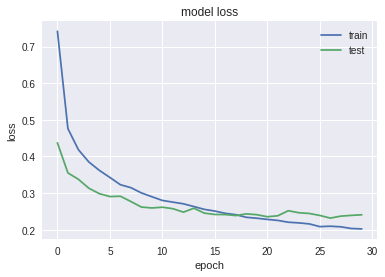

In [0]:
# Evaluate and Plot history

test_score = model.evaluate(x_test, y_test)
train_score = model.evaluate(x_train, y_train)
print(test_score)
print(train_score)
plot_train_history_loss(model_training)

## 2.2 Trasfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model's performance on training set and test set.

### Data Prep

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

# make a categorical clothing type
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


x_train_tl = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test_tl = np.asarray([cv2.resize(x, (48,48)) for x in x_test])

x_train_tl = x_train_tl.reshape(x_train_tl.shape[0], 48, 48,1)
x_test_tl  = x_test_tl.reshape(x_test_tl.shape[0], 48, 48, 1)

# make gray images into rgb images
x_train_tl = x_train_tl.repeat(3, axis=-1)
x_test_tl  = x_test_tl.repeat(3, axis=-1)

print(x_train_tl.shape)
print(x_test_tl.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [0]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

tl_model = model.fit(x_train_tl, 
          y_train,
          batch_size=128,
          shuffle=True,
          epochs=15, 
          validation_data=(x_test_tl, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 42s 708us/step - loss: 0.5586 - acc: 0.8095 - val_loss: 0.4310 - val_acc: 0.8462
Epoch 2/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3958 - acc: 0.8574 - val_loss: 0.3966 - val_acc: 0.8592
Epoch 3/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3627 - acc: 0.8684 - val_loss: 0.3912 - val_acc: 0.8576
Epoch 4/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3431 - acc: 0.8740 - val_loss: 0.3749 - val_acc: 0.8673
Epoch 5/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3268 - acc: 0.8800 - val_loss: 0.3665 - val_acc: 0.8696
Epoch 6/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3152 - acc: 0.8849 - val_loss: 0.3545 - val_acc: 0.8761
Epoch 7/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3003 - acc: 0.8904 - val_loss: 0.

In [0]:
# Evaluate the model 
score_test = model.evaluate(x_test_tl, y_test, verbose=0)
print("Test: ",score_test)
score_train = model.evaluate(x_train_tl, y_train, verbose=0)
print("Train: ",score_train)

Test:  [0.33409591370821, 0.8859]
Train:  [0.2104995892037948, 0.9241333333333334]


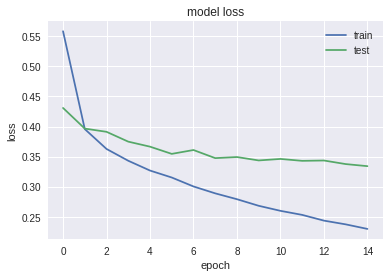

In [0]:
plot_train_history_loss(tl_model)

# 3 Text Classification

While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classifica-
tion in the context of cybersecurity.

Background. When malware infects a host computer, it often needs to
reach out to an outside server for further instructions or to download additional
payloads. This outside server is called a Command-and-Control server (C2).
The malware needs to send a specific communication to the C2 server, thus the
C2 server needs to have a registered IP address or associated web domain so
that it can be reached. Therefore, being able to identify web domains that are
likely related to malware C2 can be a valuable cyber defense.

Dataset. Fortunately, security researchers have already identified and logged
a large number of malicious URLs. Additionally, we can catalog common "be-
nign" URLs just from typical web behavior (these would include things like
facebook.com and amazon.com). Hence, we have a labeled dataset for text
classification which can be downloaded here:

 https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt

 https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt

## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classication task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

### Data Prep

In [0]:
import requests

benign_url = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text
malicious_url = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text

all_url = benign_url+'\n'+malicious_url
url_list = list(all_url.split("\n"))
ben_list = list(benign_url.split("\n"))
mal_list = list(malicious_url.split("\n"))
print(len(url_list))
print(len(ben_list))
print(len(mal_list))
# seperate class, 0 for ben, 1 for mal
label_list = [0]*len(ben_list)+[1]*len(mal_list)
print(len(label_list))

# encode urls as sequences of numbers
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(url_list)
sequence_results = tokenizer.texts_to_sequences(url_list)

# pad sequence
maxlen = max(len(x) for x in sequence_results)
sequence_results = sequence.pad_sequences(sequence_results, maxlen)

# convert to matrix
sequence_results = np.asmatrix(sequence_results)
print(sequence_results.shape)

# split test and train set
x_train, x_test, y_train, y_test = train_test_split(sequence_results, label_list, test_size=0.10, random_state=480)

# classes are very imbalanced, so define variable class_weights that can be passed during training
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

67354
66057
1297
67354
(67354, 86)


In [0]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=100,
                      output_dim=32,
                      input_length=maxlen))
rnn_model.add(Dropout(0.3))
rnn_model.add(LSTM(32, input_shape=(maxlen, 100)))
rnn_model.add(Dense(250,activation = "relu"))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(1, activation='sigmoid'))

In [0]:
rnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
rnn_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 86, 32)            3200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 86, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 250)               8250      
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 20,021
Trainable params: 20,021
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn_model_result = rnn_model.fit(x_train, y_train,
            batch_size=128,
            epochs=10,
            validation_data=(x_test, y_test),
            class_weight=class_weights)

Train on 60618 samples, validate on 6736 samples
Epoch 1/10
60618/60618 [==============================] - 112s 2ms/step - loss: 0.0703 - acc: 0.9800 - val_loss: 0.0428 - val_acc: 0.9822
Epoch 2/10
60618/60618 [==============================] - 109s 2ms/step - loss: 0.0363 - acc: 0.9831 - val_loss: 0.0313 - val_acc: 0.9862
Epoch 3/10
60618/60618 [==============================] - 111s 2ms/step - loss: 0.0308 - acc: 0.9851 - val_loss: 0.0287 - val_acc: 0.9865
Epoch 4/10
60618/60618 [==============================] - 111s 2ms/step - loss: 0.0286 - acc: 0.9857 - val_loss: 0.0281 - val_acc: 0.9866
Epoch 5/10
60618/60618 [==============================] - 109s 2ms/step - loss: 0.0278 - acc: 0.9866 - val_loss: 0.0269 - val_acc: 0.9878
Epoch 6/10
60618/60618 [==============================] - 109s 2ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 0.0258 - val_acc: 0.9877
Epoch 7/10
60618/60618 [==============================] - 110s 2ms/step - loss: 0.0265 - acc: 0.9875 - val_loss: 0.0249 - v

In [0]:
print(rnn_model.evaluate(x_test, y_test))

6736/6736 [==============================] - 18s 3ms/step
[0.02479214234768526, 0.9900534441805225]


In [0]:
# check confusion matrix
y_test_preds_rnn = rnn_model.predict(x_test, batch_size=128)
y_test_preds_class_rnn = y_test_preds_rnn > 0.5

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_test_preds_class_rnn)

array([[6556,   49],
       [  18,  113]])

## 3.2 CNN

Build and train a 1D CNN for this text classification task. You might gain some
insight and inspiration from these text classification approaches:

 http://www.aclweb.org/anthology/D14-1181

 https://arxiv.org/abs/1702.08568

### Data Prep

In [0]:
benign_url = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text
malicious_url = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text

all_url = benign_url+'\n'+malicious_url
url_list = list(all_url.split("\n"))
ben_list = list(benign_url.split("\n"))
mal_list = list(malicious_url.split("\n"))
print(len(url_list))
print(len(ben_list))
print(len(mal_list))
# seperate class, 0 for ben, 1 for mal
label_list = [0]*len(ben_list)+[1]*len(mal_list)
print(len(label_list))

# encode urls as sequences of numbers
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(url_list)
sequence_results = tokenizer.texts_to_sequences(url_list)

# pad sequence
maxlen = max(len(x) for x in sequence_results)
sequence_results = sequence.pad_sequences(sequence_results, maxlen)

# convert to matrix
sequence_results = np.asmatrix(sequence_results)
print(sequence_results.shape)

# split test and train set
x_train, x_test, y_train, y_test = train_test_split(sequence_results, label_list, test_size=0.10, random_state=480)

# classes are very imbalanced, so define variable class_weights that can be passed during training
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

67354
66057
1297
67354
(67354, 86)


In [0]:
# define model
cnn_model = Sequential()

# add embedding layer
cnn_model.add(Embedding(input_dim=100,
                      output_dim=32,
                      input_length=maxlen))

cnn_model.add(Dropout(0.2))

# add 1D Convolutional layer
cnn_model.add(Conv1D(filters=128,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))
cnn_model.add(GlobalMaxPooling1D())

# dense layer 
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dropout(0.2))

# then project onto a single unit output layer, and squash it with a sigmoid
cnn_model.add(Dense(1, activation="sigmoid"))

In [0]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 86, 32)            3200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 84, 128)           12416     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               32250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total para

In [0]:
cnn_model.fit(x_train, y_train,
            batch_size=64,
            epochs=5,
            validation_data=(x_test, y_test),
            class_weight=class_weights)

Train on 60618 samples, validate on 6736 samples
Epoch 1/5
60618/60618 [==============================] - 12s 203us/step - loss: 0.0627 - acc: 0.9816 - val_loss: 0.0304 - val_acc: 0.9877
Epoch 2/5
60618/60618 [==============================] - 8s 133us/step - loss: 0.0290 - acc: 0.9871 - val_loss: 0.0242 - val_acc: 0.9889
Epoch 3/5
60618/60618 [==============================] - 8s 132us/step - loss: 0.0242 - acc: 0.9892 - val_loss: 0.0249 - val_acc: 0.9881
Epoch 4/5
60618/60618 [==============================] - 8s 132us/step - loss: 0.0217 - acc: 0.9905 - val_loss: 0.0307 - val_acc: 0.9863
Epoch 5/5
60618/60618 [==============================] - 8s 134us/step - loss: 0.0191 - acc: 0.9914 - val_loss: 0.0188 - val_acc: 0.9902


In [0]:
print(cnn_model.evaluate(x_test, y_test))

6736/6736 [==============================] - 0s 64us/step
[0.01876810448435843, 0.9902019002375297]


In [0]:
# check confusion matrix
y_test_preds_cnn       = cnn_model.predict(x_test, batch_size=64)
y_test_preds_class_cnn   = y_test_preds_cnn > 0.5

confusion_matrix(y_test,y_test_preds_class_cnn)

array([[6573,   32],
       [  34,   97]])

## 3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don't forget to create a train-test split.

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

rnn_fp, rnn_tp, rnn_thresholds = roc_curve(y_test, y_test_preds_rnn)
rnn_auc = auc(rnn_fp, rnn_tp)

cnn_fp, cnn_tp, cnn_thresholds = roc_curve(y_test, y_test_preds_cnn)
cnn_auc = auc(cnn_fp, cnn_tp)

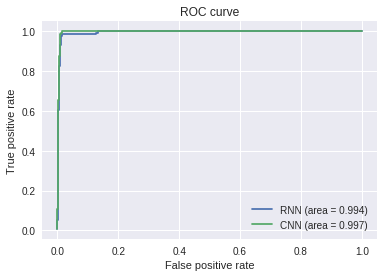

In [0]:
plt.plot(rnn_fp, rnn_tp, label='RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(cnn_fp, cnn_tp, label='CNN (area = {:.3f})'.format(cnn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()